In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power


def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


## 1. Для планирования эксперимента изучим данные и метрики 

In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [3]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


In [45]:
df['event_date'].min()

Timestamp('2019-06-18 00:00:00')

In [40]:
df['event_date'].max()

Timestamp('2019-12-09 00:00:00')

Эти данные приведены за период c **18.06.2019** по **9.12.2019**.

Посмотрим, сколько всего уникальных пользователей имеется в датасете:

In [48]:
df['user_id'].unique().shape

(1932049,)

In [49]:
df['user_id'].shape

(8625842,)

В среднем, на одного пользователя приходится 4.5 транзакции.

Рассмотрим основные статистики метрики

In [5]:
df['revenue_amount'].describe()

count    8.625842e+06
mean     4.009047e+02
std      9.602217e+02
min      1.000000e+00
25%      8.800000e+01
50%      1.670000e+02
75%      4.050000e+02
max      2.881230e+05
Name: revenue_amount, dtype: float64

Из этого саммари можно сделать предварительные выводы о следующем:

- У данных действительно большое $std = 960$;
- Выборка обладает "тяжелым хвостом", так как перцентиль 75% равен $405$, а максимум $288123$;
- Оценка среднего будет обладать большим смещением, так как $\overline{X} = 400, min = 1, max = 288123$. 

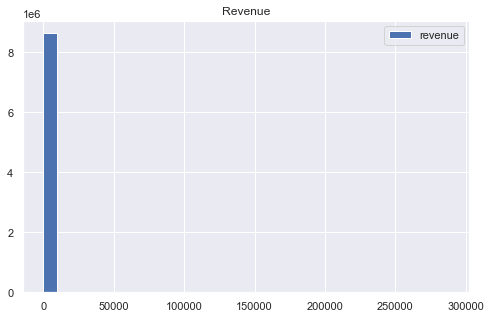

In [34]:
plt.figure(figsize=(8,5))
plt.hist(df['revenue_amount'], bins = 30, label = 'revenue')
plt.title('Revenue')
plt.legend()
plt.show()

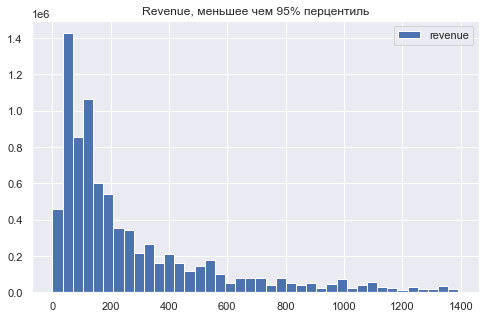

In [35]:
plt.figure(figsize=(8,5))
plt.hist(df[df['revenue_amount'] <= df['revenue_amount'].quantile(0.95)]['revenue_amount'], label = 'revenue', bins = 40)
plt.title('Revenue, меньшее чем 95% перцентиль')
plt.legend()
plt.show()

Видим, что **revenue** имеет типичное для этой метрики экспоненциальное распределение.

Изучим, как данные изменяются внутри различных групп.

- В разрезе **user_segment**:

In [63]:
df[['user_segment', 'revenue_amount']].groupby(by = 'user_segment').describe()

revenue_amount                                        \
                             count         mean          std  min    25%   
user_segment                                                               
853431062533847667       1001507.0  1094.330305  2392.330098  1.0  226.0   
2376074197230840906      4013951.0   401.615956   571.446013  4.0  109.0   
4626944681007198896      3610384.0   207.760172   285.545686  4.0   63.0   

                                              
                       50%     75%       max  
user_segment                                  
853431062533847667   489.0  1113.0  288123.0  
2376074197230840906  209.0   475.0   52540.0  
4626944681007198896  112.0   230.0   19950.0

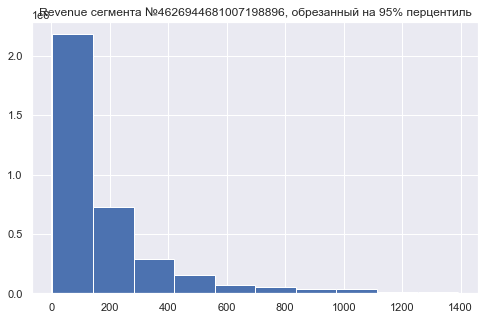

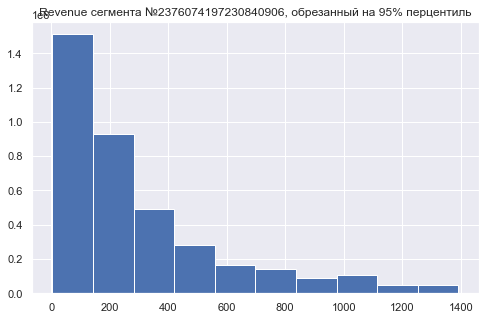

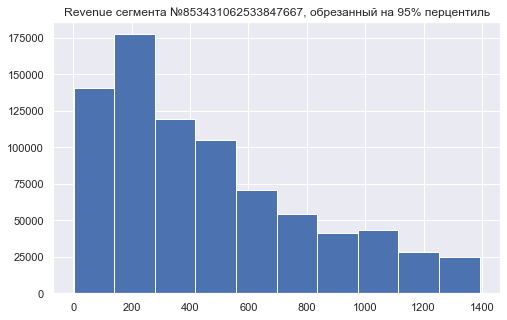

In [27]:
segments = df['user_segment'].unique()

for seg in segments:
    plt.figure(figsize=(8,5))
    data = df[(df['user_segment'] == seg) & (df['revenue_amount'] <= df['revenue_amount'].quantile(0.95))]['revenue_amount']
    plt.title(f'Revenue сегмента №{seg}, обрезанный на 95% перцентиль')
    plt.hist(data)
    plt.show()

- В разрезе **category**:

In [66]:
df[['category', 'revenue_amount']].groupby(by = 'category').describe()

revenue_amount                                         \
                             count         mean          std   min    25%   
category                                                                    
57514010642945023         689886.0   347.826167   605.864274  20.0  109.0   
91460430793700892         280512.0   441.861699   651.938097  11.0  112.0   
174490086998335078        379803.0   325.149759   764.813512   1.0   62.0   
264558924403680107        122114.0   509.373364   747.222091  27.0  132.0   
282115902545472456         41960.0   260.778575   354.734991  11.0   84.0   
320230973495659885         80051.0   286.013254   414.997017   6.0   70.0   
1472231361867825698       627129.0   258.353200   594.984151   4.0   56.0   
1560592244484430230       204558.0   313.285665   464.354426  13.0  111.0   
1793067034829450750       344271.0   497.431001  1073.795206  15.0  118.0   
2343719193625129042        73500.0   943.989905  2471.247604  17.0  160.0   
2923341857645916506       157820.0   806.675364  1613.975843  25.0  188.0   
2965866302161963961        81507.0   196.501761   350.682200   6.0   49.0   
3187769798308634693       767177.0   467.654020   790.312625  11.0  118.0   
3358911609809004109        19222.0   403.792946   791.225418  14.0   90.0   
3429514168013826643       229608.0   200.418644   281.092885   8.0   63.0   
3619272498251215842        42503.0   142.088606   172.984799   6.0   49.0   
4394253463123676325       580595.0   136.595029   300.843418   6.0   39.0   
4409084324312788296       265629.0   379.733922   889.850240   7.0   70.0   
4546178272531746227       103201.0   510.431362   717.762308   8.0  119.0   
4658595883120885993        65457.0   215.218327   279.414560   8.0   63.0   
5284347926600386297        50676.0   455.255782   534.420842  20.0  140.0   
5387097547938806535        28114.0   149.053532   196.446707   8.0   48.0   
5736208844128861898        42636.0   321.823084   625.686617  14.0   69.0   
5858189596811644833         3837.0   527.746677   699.154653  20.0  134.0   
5983323600580891431       480199.0   433.565037   535.078480  11.0  118.0   
6549025562984299367       725571.0   410.800302  1899.114650  20.0   69.0   
6742557862815872936       267764.0   503.182713   778.842570  14.0  132.0   
6847326422676498281       105945.0   167.567493   311.475321   4.0   49.0   
6864443610550051939       126825.0   233.014721   471.848055   6.0   56.0   
7164285449278522823        12835.0  1955.979431  3164.815179  21.0  447.0   
7204754148424990691       736535.0   352.174948   511.821260   4.0   90.0   
7247164925237372155       189671.0   155.169288   285.421869   6.0   49.0   
7948270325129383019       698731.0   792.677807  1352.172272  11.0  209.0   

                                               
                        50%     75%       max  
category                                       
57514010642945023     167.0   369.0   42271.0  
91460430793700892     231.0   518.0   41867.0  
174490086998335078    132.0   291.0   51403.0  
264558924403680107    279.0   622.0   40908.0  
282115902545472456    160.0   302.0   15630.0  
320230973495659885    140.0   329.0   19950.0  
1472231361867825698   112.0   231.0   30429.0  
1560592244484430230   167.0   370.0   29030.0  
1793067034829450750   244.0   524.0  140792.0  
2343719193625129042   391.0   922.0  164262.0  
2923341857645916506   405.0   921.0   57673.0  
2965866302161963961    98.0   203.0   17500.0  
3187769798308634693   244.0   524.0   47314.0  
3358911609809004109   168.0   445.0   21740.0  
3429514168013826643   119.0   224.0   10913.0  
3619272498251215842    98.0   161.0    5494.0  
4394253463123676325    70.0   140.0   46074.0  
4409084324312788296   140.0   329.0   36470.0  
4546178272531746227   245.0   651.0   18907.0  
4658595883120885993   119.0   245.0    8904.0  
5284347926600386297   258.0   574.0    8848.0  
5387097547938806535    83.0   160.0    3001.0  
5736208844128861898   160.0   321.0   20083.0  

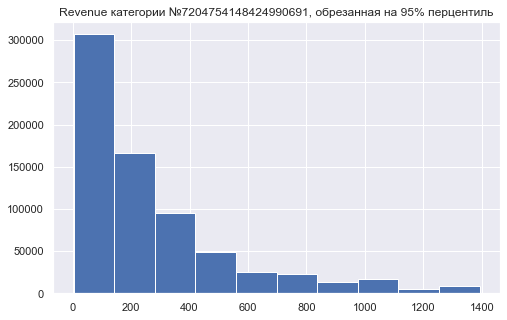

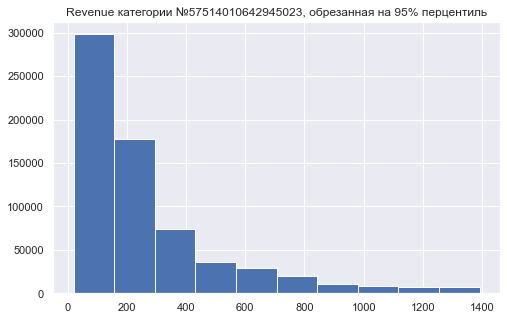

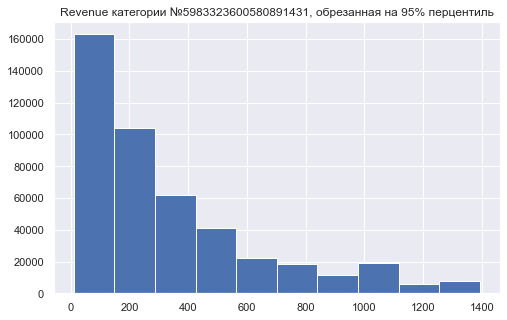

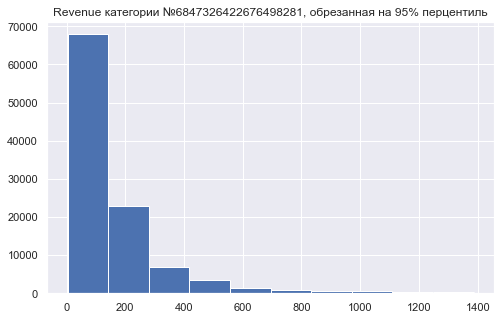

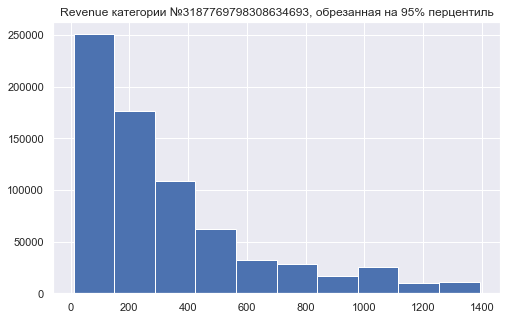

In [26]:
categ = df['category'].unique()[:5]

for cat in categ:
    plt.figure(figsize=(8,5))
    data = df[(df['category'] == cat) & (df['revenue_amount'] <= df['revenue_amount'].quantile(0.95))]['revenue_amount']
    plt.title(f'Revenue категории №{cat}, обрезанная на 95% перцентиль')
    plt.hist(data)
    plt.show()

- В разрезе **region**:

In [4]:
df[['region', 'revenue_amount']].groupby(by = 'region').describe()

revenue_amount                                             \
                             count        mean         std  min    25%    50%   
region                                                                          
68475388295793322          95906.0  289.345317  504.681673  6.0  78.00  134.0   
181387893390186210         40756.0  299.629748  461.930430  8.0  70.00  140.0   
308194675497345788         22341.0  252.626919  544.986118  6.0  70.00  129.0   
385667469633138042         59486.0  272.589534  507.917500  6.0  69.00  132.0   
405364780634206711          1040.0  205.209615  295.197711  8.0  63.75  112.0   
...                            ...         ...         ...  ...    ...    ...   
9030439280442565223        63862.0  241.213507  374.722208  4.0  58.00  116.0   
9032475813655386611        75065.0  341.125571  583.562907  6.0  70.00  161.0   
9159753098538066161        50486.0  324.889870  721.907652  6.0  90.00  148.0   
9173615405044165275         3073.0  189.498536  230.607352  6.0  55.00  124.0   
9198008870977546443       108923.0  369.359878  613.172957  6.0  90.00  174.0   

                                     
                       75%      max  
region                               
68475388295793322    328.0  31816.0  
181387893390186210   328.0  13170.0  
308194675497345788   280.0  22775.0  
385667469633138042   284.0  23471.0  
405364780634206711   231.0   5121.0  
...                    ...      ...  
9030439280442565223  272.0  18971.0  
9032475813655386611  391.0  33244.0  
9159753098538066161  335.0  33051.0  
9173615405044165275  196.0   3538.0  
9198008870977546443  392.0  19725.0  

[84 rows x 8 columns]

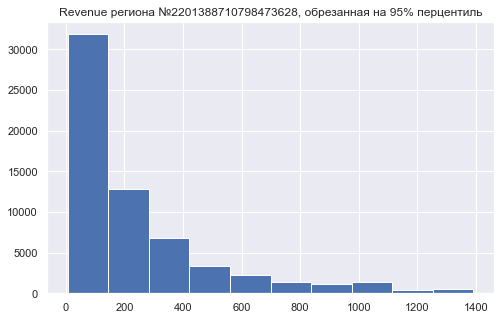

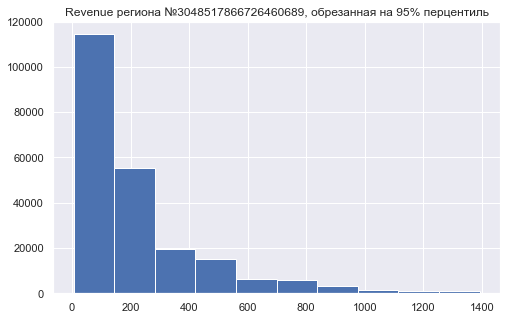

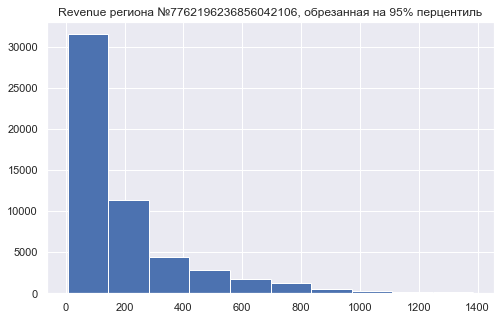

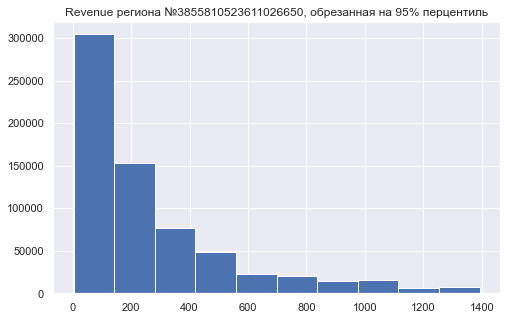

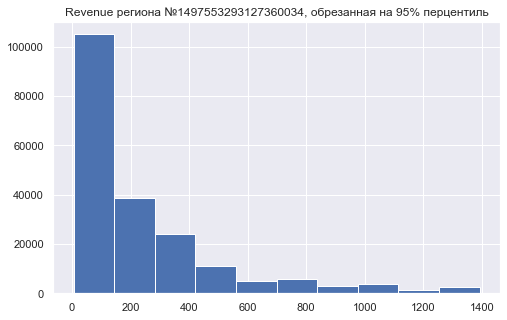

In [6]:
region = df['region'].unique()[:5]

for reg in region:
    plt.figure(figsize=(8,5))
    data = df[(df['region'] == reg) & (df['revenue_amount'] <= df['revenue_amount'].quantile(0.95))]['revenue_amount']
    plt.title(f'Revenue региона №{reg}, обрезанная на 95% перцентиль')
    plt.hist(data)
    plt.show()

## 2. Предскажите минимально детектируемый эффект (MDE) 2 балла

Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект

Посмотрим, как менялась выручка по дням на всем датасете:

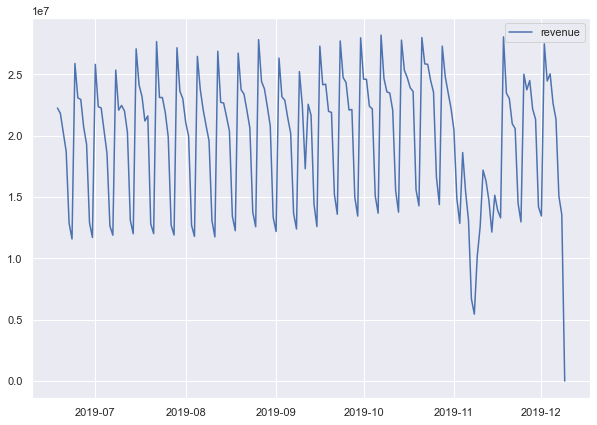

In [24]:
plt.figure(figsize=(10,7))
data = df[['event_date', 'revenue_amount']].groupby(by = 'event_date').sum()
plt.plot(data, label = 'revenue')
plt.legend()
plt.show()

In [4]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data['event_date']>=start_date)&(data['event_date']<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

#r - доля тестовой выборки от всей выборки
def get_mde(sample, r, alpha = 0.05, power = 0.8) -> float:
    sample = sample.iloc[sample.index < sample.shape[0]*r]
    mean = np.mean(sample)
    std = np.std(sample)
    n = len(sample)
    SE = tt_ind_solve_power(alpha=alpha, power=power, nobs1=n, ratio=r/(1-r), alternative = 'two-sided')
    mde = (SE*std)/mean
    return mde

def get_mde_from_stats(mean, std, n, r, alpha = 0.05, power = 0.8) -> float:
    SE = tt_ind_solve_power(alpha=alpha, power=power, nobs1=n, ratio=r/(1-r), alternative = 'two-sided')
    mde = (SE*std)/mean
    return mde

def to_fixed(numObj, digits=0):
    return f"{numObj:.{digits}f}"

def date_mask(df, from_date, to_date):
    return (df <= to_date) & (df >= from_date)  

def cuped(metric, pre_period):
    theta = np.cov(metric, pre_period)[0,1]/np.var(pre_period)
    cuped_metric = metric - theta*(pre_period - np.mean(pre_period))
    return cuped_metric

Из графика выше видно, что **2019-12-09** произошло крупное падение выручки. Это может плохо повлиять на оценку дисперсии, поэтому исключим этот день из рассмотрения. Зафиксируем период из 3 месяцев.

In [5]:
dataupd = df[date_mask(df['event_date'], '2019-08-01', '2019-11-01')]

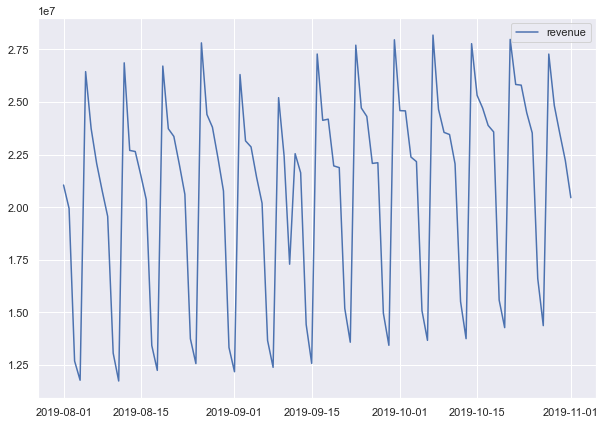

In [6]:
plt.figure(figsize=(10,7))
plt.plot(dataupd[['event_date', 'revenue_amount']].groupby(by = 'event_date').sum(), label = 'revenue')
plt.legend()
plt.show()

In [12]:
start = datetime.datetime(2019, 8, 1, 0, 0)

for days in range(3, 10, 3):
    for sh in [0.1, 0.25, 0.5]:
        data = choose_date(dataupd, start, days*10, 1 - sh)
        print(f'Продолжительность эксперимента {days*10} дней, share = {to_fixed(sh*100, 0)}%, MDE = {to_fixed(100*get_mde(data.revenue_amount, r = sh), 5)} %')

Продолжительность эксперимента 30 дней, share = 10%, MDE = 8.19156 %
Продолжительность эксперимента 30 дней, share = 25%, MDE = 6.09293 %
Продолжительность эксперимента 30 дней, share = 50%, MDE = 6.28709 %
Продолжительность эксперимента 60 дней, share = 10%, MDE = 7.89497 %
Продолжительность эксперимента 60 дней, share = 25%, MDE = 5.88349 %
Продолжительность эксперимента 60 дней, share = 50%, MDE = 5.95972 %
Продолжительность эксперимента 90 дней, share = 10%, MDE = 8.07972 %
Продолжительность эксперимента 90 дней, share = 25%, MDE = 6.00466 %
Продолжительность эксперимента 90 дней, share = 50%, MDE = 5.97114 %


Видим, что наименьший MDE дает эксперимент длиной 60 дней с отношением тестовой выборки в 50%.

## 3. CUPED

- **Рассчитайте CUPED метрику на основе данных для периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней.**

Выберем промежуток в последние 30 дней, имеющихся в датасете.

In [47]:
start_date = datetime.datetime(2019, 11, 1, 0, 0)
pre_date = datetime.datetime(2019, 10, 1, 0, 0)


revenue30d = choose_date(df,start_date, 29, 1)[['user_id', 'revenue_amount']]
revenue30d

,user_id,revenue_amount
0,1912219714366,714.0
1,7562887359106,139.0
2,23708868092799,192.0
3,39239811475386,259.0
4,51991933272698,8119.0
...,...,...
536891,9223185124256504791,105.0
536892,9223201604511412042,49.0
536893,9223221513659911088,868.0
536894,9223353766165032250,48.0


Создадим выборку предпериода:

In [101]:
revenue30d_pre = choose_date(df,pre_date, 29, 1)[['user_id', 'revenue_amount']]
revenue30d_pre

,user_id,revenue_amount
0,702221222224,356.0
1,1912219714366,70.0
2,23708868092799,144.0
3,39239811475386,195.0
4,45305541518475,250.0
...,...,...
587310,9223321829799437693,293.0
587311,9223348554567144516,70.0
587312,9223353766165032250,25.0
587313,9223366785772814828,4448.0


Сделаем джойн этих таблиц по пользователям

In [102]:
joinreven30d = revenue30d.merge(revenue30d_pre, left_on = 'user_id', right_on = 'user_id', how = 'left')
joinreven30d = joinreven30d.rename(columns = {'revenue_amount_x': 'revenue', 'revenue_amount_y': 'pre_revenue'})

In [103]:
joinreven30d['pre_revenue'] = joinreven30d['pre_revenue'].fillna(0)

Вычислим CUPED-метрику **cuped_revenue**.

In [104]:
joinreven30d['cuped_revenue'] = cuped(joinreven30d['revenue'], joinreven30d['pre_revenue'])
joinreven30d

,user_id,revenue,pre_revenue,cuped_revenue
0,1912219714366,714.0,70.0,1192.485581
1,7562887359106,139.0,0.0,667.077393
2,23708868092799,192.0,144.0,618.059950
3,39239811475386,259.0,195.0,648.928773
4,51991933272698,8119.0,1209.0,7790.555945
...,...,...,...,...
536891,9223185124256504791,105.0,0.0,633.077393
536892,9223201604511412042,49.0,0.0,577.077393
536893,9223221513659911088,868.0,0.0,1396.077393
536894,9223353766165032250,48.0,25.0,558.366032


Посмотрим, как изменилось среднеквадратичное отклонение для данной метрики до и после CUPED.

In [105]:
np.std(joinreven30d['revenue'])/np.std(joinreven30d['cuped_revenue'])

1.4677162294921704

Как видно, std уменьшилось в 2 раза.

Сравним MDE до и после CUPED:

In [142]:
mde = get_mde(joinreven30d['revenue'], r = 0.5)*100
mde_cuped = get_mde(joinreven30d['cuped_revenue'], r = 0.5)*100

print(f'MDE = {to_fixed(mde,3)}%, MDE with CUPED = {to_fixed(mde_cuped)}%')

MDE = 5.469%, MDE with CUPED = 4%


MDE с CUPED значительно уменьшился, следовательно, тест стал лучше.

- **Проверим, насколько данный подход подвержен сезональности и как меняется MDE, если применять данный подход в разные периоды.**

Автоматизируем подсчет MDE и CUPED MDE с помощью следующего метода

In [6]:
def cuped_sample(sample, pre_sample):
    joined = sample.merge(pre_sample, left_on = 'user_id', right_on = 'user_id', how = 'left')
    joined = joined.rename(columns = {'revenue_amount_x': 'revenue', 'revenue_amount_y': 'pre_revenue'})
    joined['pre_revenue'] = joined['pre_revenue'].fillna(0)
    joined['cuped_revenue'] = cuped(joined['revenue'], joined['pre_revenue'])
    return joined

In [42]:
cuped_sample(revenue30d,revenue30d_pre, 0.5)

,revenue,pre_revenue,cuped_revenue
user_id,,,
1912219714366,714.0,0.0,1361.514869
7562887359106,139.0,0.0,786.514869
23708868092799,192.0,370.0,590.655844
39239811475386,259.0,294.0,708.772833
51991933272698,8119.0,5235.0,5245.495967
...,...,...,...
9223185124256504791,105.0,49.0,719.557863
9223201604511412042,49.0,0.0,696.514869
9223221513659911088,868.0,0.0,1515.514869


Рассмотрим CUPED в следующие периоды длиной месяц:

 - Период с 2019-09-01 , предпериод с 2019-08-02
 - Период с 2019-09-15 , предпериод с 2019-08-16
 - Период с 2019-10-01 , предпериод с 2019-09-01
 - Период с 2019-10-15 , предпериод с 2019-09-15
 - Период с 2019-11-01 , предпериод с 2019-10-02
 - Период с 2019-11-15 , предпериод с 2019-10-16


In [143]:
months = [9, 10, 11]
days = [1, 15]
r = 0.5

for month in months:
    for day in days:
        start_date = datetime.datetime(2019, month, day)
        pre_date = datetime.datetime(2019, month, day) - datetime.timedelta(days=30)
        revenue = choose_date(df,start_date, 29, 1)[['user_id', 'revenue_amount']]
        pre_revenue = choose_date(df,pre_date, 29, 1)[['user_id', 'revenue_amount']]
        cuped_revenue = cuped_sample(revenue, pre_revenue)
        mde = get_mde(cuped_revenue['revenue'], r = 0.5)*100
        mde_cuped = get_mde(cuped_revenue['cuped_revenue'], r = 0.5)*100
        print(f'Период с {start_date.date()} по {(start_date + datetime.timedelta(days=29)).date()}, предпериод с {pre_date.date()} по {(pre_date + datetime.timedelta(days=29)).date()}:')
        print(f'  • MDE = {to_fixed(mde,2)}%')
        print(f'  • CUPED MDE = {to_fixed(mde_cuped, 2)}%')

Период с 2019-09-01 по 2019-09-30, предпериод с 2019-08-02 по 2019-08-31:
  • MDE = 4.77%
  • CUPED MDE = 2.43%
Период с 2019-09-15 по 2019-10-14, предпериод с 2019-08-16 по 2019-09-14:
  • MDE = 5.36%
  • CUPED MDE = 2.68%
Период с 2019-10-01 по 2019-10-30, предпериод с 2019-09-01 по 2019-09-30:
  • MDE = 5.47%
  • CUPED MDE = 2.43%
Период с 2019-10-15 по 2019-11-13, предпериод с 2019-09-15 по 2019-10-14:
  • MDE = 5.53%
  • CUPED MDE = 2.49%
Период с 2019-11-01 по 2019-11-30, предпериод с 2019-10-02 по 2019-10-31:
  • MDE = 5.47%
  • CUPED MDE = 2.61%
Период с 2019-11-15 по 2019-12-14, предпериод с 2019-10-16 по 2019-11-14:
  • MDE = 5.16%
  • CUPED MDE = 2.47%


**Вывод:** сезональность, которая есть в данных, влияет на MDE, но незначительно. В данном случае это вызвано тем, что сезоны в данном случае проявляют себя слабо, образуя практически стационарный ряд.

- **Оптимизируем подход, варьируя количество дней до теста, которые будем брать для расчёта CUPED метрики. Найдем максимальное снижение MDE**.

Пусть мы хотим провести эксперимент в период  с **2019-12-01** по **2019-12-30**. Будем замерять MDE на периоде **2019-11-01** по **2019-11-30**. При этом предпериод будем сдвигать с шагом в 10 дней в прошлое, замеряя MDE.

In [14]:
start_date = datetime.datetime(2019, 11, 1)
pre_date = datetime.datetime(2019, 6, 9)
step = 9
r = 0.5
mde_array = []
datas = []
revenue = choose_date(df,start_date, 29, 1)[['user_id', 'revenue_amount']]

print(f'Основной период есть {start_date.date()}, предпериоды: ')
while pre_date + 2*datetime.timedelta(days=step) < start_date:
    pre_date = pre_date + datetime.timedelta(days=step + 1)
    revenue = choose_date(df,start_date, 29, 1)
    pre_revenue = choose_date(df,pre_date, 10, 1)
    cuped_revenue = cuped_sample(revenue[['user_id', 'revenue_amount']], pre_revenue[['user_id', 'revenue_amount']])
    cuped_mde = get_mde(cuped_revenue['cuped_revenue'], r = 0.5)*100
    mde_array.append(cuped_mde)
    datas.append(pre_date)
    print(f' • {pre_date.date()} до {(pre_date + datetime.timedelta(days=step)).date()} => CUPED MDE = {to_fixed(cuped_mde,2)}%')

Основной период есть 2019-11-01, предпериоды: 
 • 2019-06-19 до 2019-06-28 => CUPED MDE = 4.30%
 • 2019-06-29 до 2019-07-08 => CUPED MDE = 4.15%
 • 2019-07-09 до 2019-07-18 => CUPED MDE = 4.61%
 • 2019-07-19 до 2019-07-28 => CUPED MDE = 3.97%
 • 2019-07-29 до 2019-08-07 => CUPED MDE = 3.92%
 • 2019-08-08 до 2019-08-17 => CUPED MDE = 4.04%
 • 2019-08-18 до 2019-08-27 => CUPED MDE = 3.67%
 • 2019-08-28 до 2019-09-06 => CUPED MDE = 3.48%
 • 2019-09-07 до 2019-09-16 => CUPED MDE = 2.96%
 • 2019-09-17 до 2019-09-26 => CUPED MDE = 2.98%
 • 2019-09-27 до 2019-10-06 => CUPED MDE = 3.20%
 • 2019-10-07 до 2019-10-16 => CUPED MDE = 2.74%
 • 2019-10-17 до 2019-10-26 => CUPED MDE = 2.77%


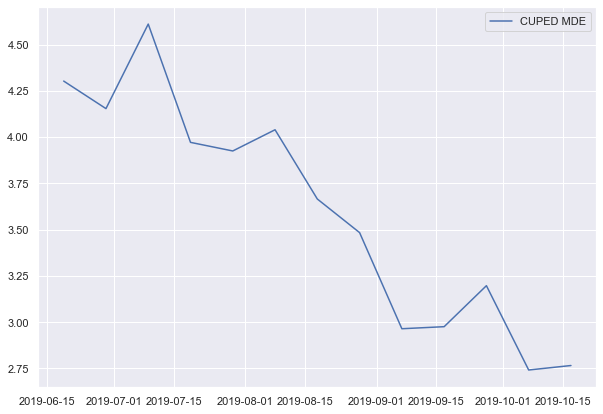

In [18]:
plt.figure(figsize=(10,7))
plt.plot(datas, mde_array, label = 'CUPED MDE')
plt.legend()
plt.show()

Видим, что чем ближе предпериод выбирался к основному периоду, тем меньше был CUPED MDE, и, тем самым, лучше критерий. Это можно объяснить тем, что пользователи в основном периоде гораздо вероятнее встречаются в данном периоде, а не в далеком прошлом.

Например, число пользователей в данном периоде, совершавших транзакции за 10 дней до начала периода есть:

In [39]:
len(np.intersect1d(choose_date(df,start_date - datetime.timedelta(days=20), 10, 1)['user_id'], choose_date(df,start_date, 29, 1)['user_id']))

160975

Число пользователей в данном периоде, совершавших транзакции за 90 дней до начала периода есть:

In [40]:
len(np.intersect1d(choose_date(df,start_date - datetime.timedelta(days=100), 10, 1)['user_id'], choose_date(df,start_date, 29, 1)['user_id']))

109633

Очевидно, что их стало значительно меньше.

**Вывод по заданию:** в CUPED стоит брать предпериод, который является ближайшим к данному периоду. 

## 4. Стратификация

- **Стратифицируйте выборки внутри срезов user_segment, region, category. Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.**

В данном задании мы будем выполнять пост-стратификацию, при этом доли страт будем брать из исторических данных. Напишем метод, который по заданной категории будет получать стратифицированное среднее и дисперсию.

In [224]:
test = df[:100000]
test

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
99995,2019-06-18,487273082120233739,4626944681007198896,91460430793700892,690419174463540260,139
99996,2019-06-18,491901550673056588,2376074197230840906,5983323600580891431,8867014108346120905,111
99997,2019-06-18,492035189034133244,4626944681007198896,3429514168013826643,3855810523611026650,97
99998,2019-06-18,502060020254352160,2376074197230840906,3187769798308634693,3855810523611026650,573


In [236]:
us1 = np.array(test[test['category'] == 7204754148424990691]['user_id'])
us2 = np.array(test[test['category'] == 91460430793700892]['user_id'])

In [237]:
np.intersect1d(us1, us2)

array([ 312030881033080760,  956381695795534332, 1026896402750839972,
       1053525293755709130, 1104468119842326269, 1583488658620102924,
       2030882421007819096, 2287653600390440550, 2748138336924098804,
       3587609298491657123, 3893148842542284829, 4291411495989443907,
       4546742597609611739, 4629591464721406923, 4767601965509834333,
       4845976995270638076, 5097868406965225144, 5190369750704445900,
       5196957028930357221, 5344267903461573023, 6017396673204177877,
       6451109199929342305, 6523843366195877737, 6683092900011841116,
       7055764867585774826, 7722524678348852014, 8420932598361291066,
       8445123150393835991, 8485015432386287140, 8851992079499799900],
      dtype=int64)

1. Стратифицируем выборку по **user_segment**. Мы заранее знаем, что пользователи в различных сегментах не пересекаются, поэтому сгруппируем действия пользователей в заданных сегментах.

In [218]:
segmented_users = test.groupby(by = ['user_id', 'category'])['revenue_amount'].mean().to_frame()
segmented_users

,,revenue_amount
user_id,category,
277934167554935,7204754148424990691,251.0
333739223557249,1472231361867825698,42.0
543409855299780,6864443610550051939,132.0
558419615518316,1560592244484430230,321.0
604634251309011,174490086998335078,62.0
...,...,...
9221902625926189030,91460430793700892,245.0
9221965353179967195,7204754148424990691,160.0
9221979404917458468,4394253463123676325,273.0


In [142]:
def strat_probs(datafr, grouping, field):
    smp = datafr[[grouping, field]].groupby(by = grouping).count()/datafr[[grouping, field]].shape[0]
    smp = smp.rename(columns = {field: 'prob'})
    return smp

In [194]:
def post_strat(datafr, probs, grouping, field):
    n = datafr.shape[0]
    smp = datafr.groupby(by =  grouping).std()
    smp = smp.rename(columns = {field: 'std'})
    smp['means'] = datafr.groupby(by =  grouping).mean()
    smp = smp.merge(probs, left_on=grouping, right_on=grouping)
    strat_mean = smp['means']@smp['prob']
    strat_var = (1/n)*((np.array(smp['std'])**2)@np.array(smp['prob'])) + (1/n**2)*((1 - np.array(smp['prob'])@np.array(smp['std']))**2)
    return strat_mean, (strat_var)**0.5

In [203]:
probabil = strat_probs(df, 'category', 'revenue_amount')

In [219]:
post_strat(segmented_users, probabil,  'category', 'revenue_amount')

(378.63158943328585, 2.4930854827506232)

In [220]:
segmented_users['revenue_amount'].mean()

379.85329134928935

In [221]:
segmented_users['revenue_amount'].sem()

2.583088347323215

Дисперсия и ошибка среднего для этого датасета без стратификации есть:

In [6]:
(df['revenue_amount'].mean(), df['revenue_amount'].sem())

(400.9046571917269, 0.32694205319458997)

1. Для страты **user_segment**

In [7]:
post_strat(df, 'user_segment', 'revenue_amount')

(400.9046571917269, 0.31402051662122665)

$\overline{X}_{strat} = 400.9, var(\overline{X}_{strat}) = 0.098$ для **user_segment**.

2. Для страты **category**

In [8]:
post_strat(df, 'category', 'revenue_amount')

(400.904657191727, 0.32066253319877325)

$\overline{X}_{strat} = 400.9, var(\overline{X}_{strat}) = 0.102$ для **category**.

3. Для страты **region**

In [9]:
post_strat(df, 'region', 'revenue_amount')

(400.904657191727, 0.3229770897369023)

$\overline{X}_{strat} = 400.9, \overline{X}_{strat} = 0.104$ для **region**.

- **В каких срезах достигается наибольшее снижение MDE?**

- **Доп. задание от Алексея: соединить CUPED со стратификацией и посмотреть что будет**